In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import warnings
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical, Integer, Continuous
from sklearn.metrics import make_scorer
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,  cross_validate
from sklearn.preprocessing import StandardScaler
import time
import sys, os
from sklearn.pipeline import make_pipeline


path = 'datasets/Dataset_2.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name="preproc")





INPUT DATA

In [5]:
X = (df.iloc[:,14:]).values
print(X.shape)
std_scaler = StandardScaler()

(2905, 530)


OUTPUT DATA

In [6]:
Y = (df.iloc[:,7]).values
print(Y.shape)

(2905,)


**NRMSEPiqr**

In [7]:


def NRMSEPiqr(observed_values, predicted_values):
    # Calculate RMSEP
    rmsep = np.sqrt(np.mean((observed_values - predicted_values) ** 2))
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(observed_values, 25)
    Q3 = np.percentile(observed_values, 75)

    # Calculate IQR
    IQR = Q3 - Q1

    return rmsep/IQR

NRMSEPiqrscorer = make_scorer(NRMSEPiqr,greater_is_better=False)


SVR

0.25
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	50    	-0.64293	0.069745   	-0.563856  	-0.843129  
1  	100   	-0.700988	0.0708799  	-0.584122  	-0.846366  
2  	100   	-0.757793	0.0622954  	-0.615039  	-0.847664  
3  	100   	-0.793014	0.0498962  	-0.63713   	-0.847664  
4  	100   	-0.812889	0.0382174  	-0.707418  	-0.847664  
5  	100   	-0.828213	0.0346989  	-0.65033   	-0.851915  
6  	100   	-0.844091	0.00835992 	-0.817408  	-0.851915  
7  	100   	-0.836926	0.0355265  	-0.669451  	-0.851915  
8  	100   	-0.84072 	0.0261464  	-0.669451  	-0.851915  
9  	100   	-0.846734	0.00719232 	-0.821114  	-0.851915  
10 	100   	-0.846506	0.00677263 	-0.821467  	-0.851915  
11 	100   	-0.847608	0.00677359 	-0.823464  	-0.851915  
12 	100   	-0.841197	0.0304304  	-0.670538  	-0.851915  
13 	100   	-0.844857	0.0263319  	-0.664052  	-0.851915  
14 	100   	-0.846639	0.00834893 	-0.821866  	-0.852018  
15 	100   	-0.849608	0.00296105 	-0.837214  	-0.852018  
16 	100   	-0.845488	0.02907

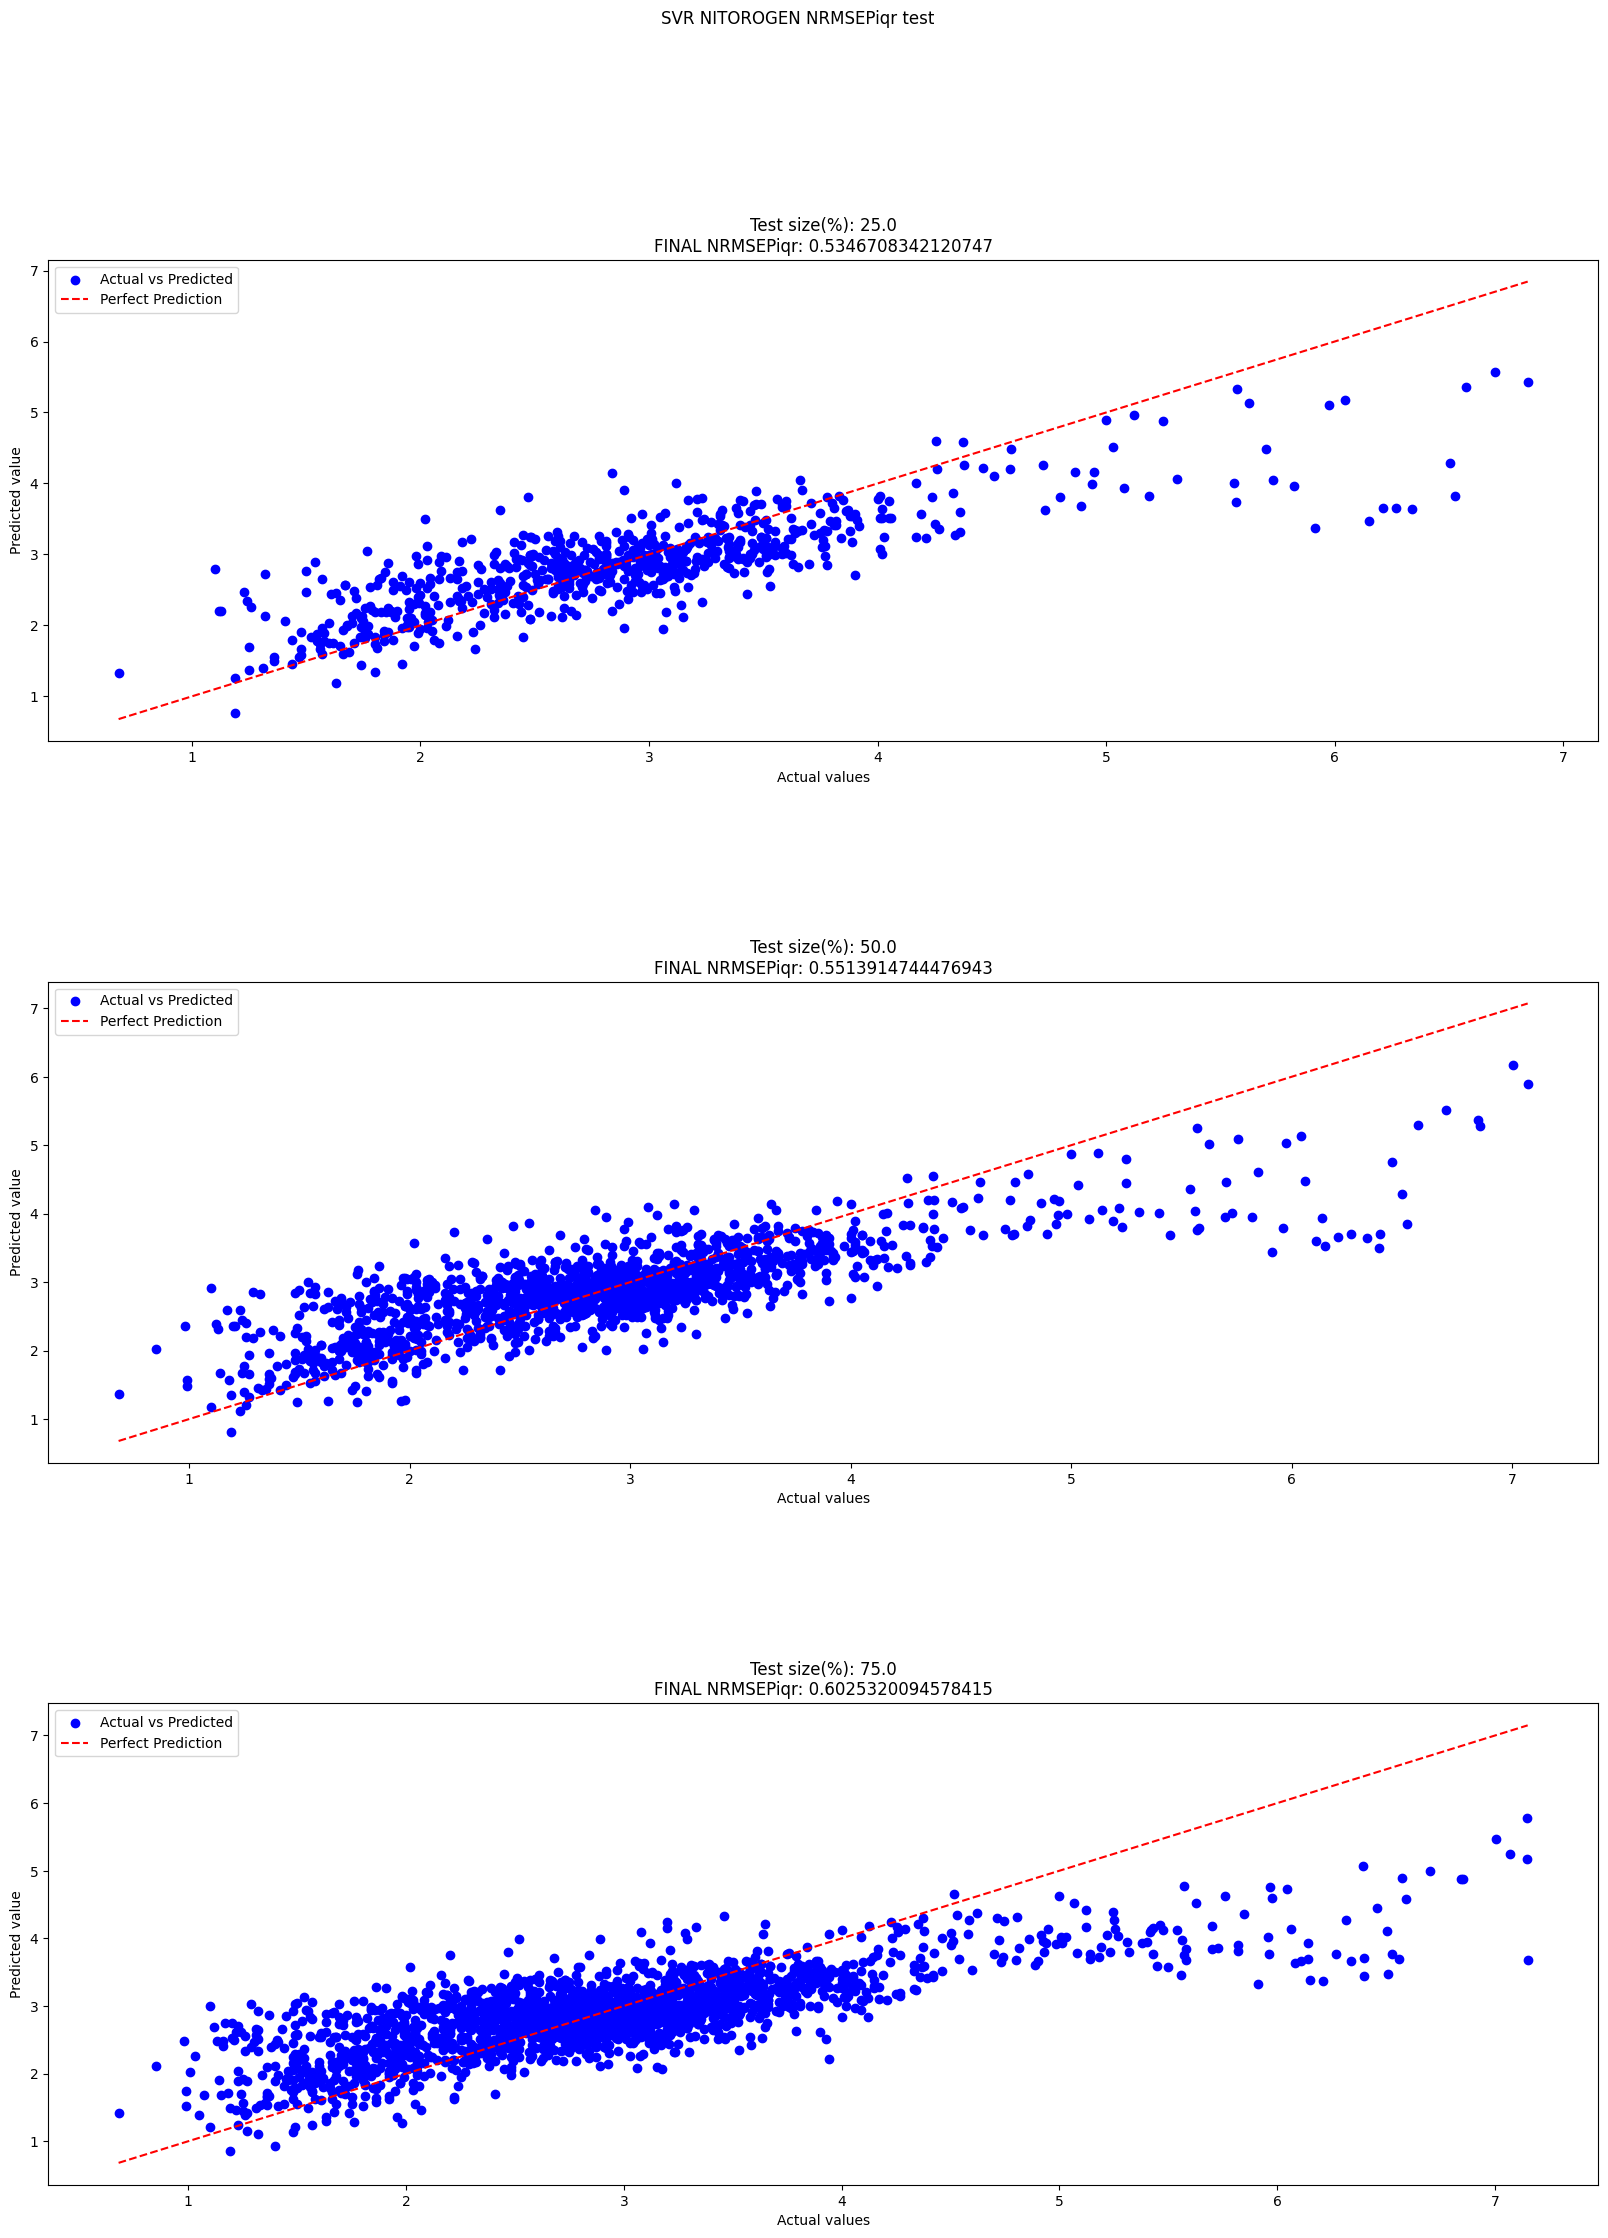

In [8]:

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 


np.random.seed(42)

ripartisions = [0.25,0.5,0.75]
results = []  

# create 3x1 subfigs
fig, axs = plt.subplots(3, 1,figsize=(20, 25),gridspec_kw={'hspace': 0.5})
fig.suptitle('SVR NITOROGEN NRMSEPiqr test' + "\n")
axs = axs.flatten()
k = 0

for ripartition in ripartisions:
  
    NRMSEP = []

    print(ripartition)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=ripartition, random_state=42) 
    param_grid = {'C': Continuous(1/10000,10),"epsilon":Continuous(1/100000,1)}
    sturges = int(1 + np.log(len(X_train)))    
    evolved_estimator = GASearchCV(estimator=SVR(),
                                    cv=sturges,
                                    scoring=NRMSEPiqrscorer,
                                    param_grid=param_grid,
                                    n_jobs=-1,
                                    verbose=True,
                                    population_size=50,
                                    generations=100,
                                    criteria = "min")
    

    start_time = time.time()
    evolved_estimator.fit(X_train, Y_train)
    elapsed_time = (time.time() -start_time) #elapsed time in seconds

    print("Best value of C: ", str(evolved_estimator.best_params_["C"]))
    print("Best value of epsilon: ", str(evolved_estimator.best_params_["epsilon"]))

    best_model =  evolved_estimator.best_estimator_
    cv_scores = cross_validate(best_model, X_train, Y_train, cv=sturges, scoring=NRMSEPiqrscorer,n_jobs=-1)      
    Y_pred_svr = best_model.predict(X_test)

    results.append([str(ripartition *100 ),-np.mean(cv_scores['test_score']), np.var(cv_scores['test_score']),
                    np.mean(cv_scores['fit_time']), elapsed_time, NRMSEPiqr(Y_test, Y_pred_svr),float(evolved_estimator.best_params_["C"]),float(evolved_estimator.best_params_["epsilon"])])

    # Display results
    print("Cross-validation NRMSEPiqr scores:", cv_scores['test_score'])
    print("Training times (seconds):", cv_scores['fit_time'])
    print("Scoring times (seconds):", cv_scores['score_time'])
    print("Final training time (seconds):", elapsed_time)
    print("Final NRMSEPiqr: ",  NRMSEPiqr(Y_test, Y_pred_svr))


           
    '''PLOT THE FINAL MODELS'''
    axs[k].scatter(Y_test, Y_pred_svr, c='blue', label='Actual vs Predicted')
    axs[k].plot([min(Y_test), max(Y_test)],
                    [min(Y_test), max(Y_test)], '--', c='red', label='Perfect Prediction')
    axs[k].legend()
    axs[k].set_xlabel("Actual values")
    axs[k].set_ylabel("Predicted value")
    axs[k].set_title( f"Test size(%): {ripartition * 100}" "\n" + "FINAL NRMSEPiqr: " + str(NRMSEPiqr(Y_test, Y_pred_svr)))
    k += 1

'''SHOW RESULTS'''

headers = ["Test size(%)", "Mean CV NRMSEPiqr", "Var CV NRMSEPiqr)","Mean CV Training Time (sec)" ,"Final training time (sec)","Final NRMSEPiqr","C","epsilon"]
print(tabulate(results, headers,  tablefmt="double_outline"))
